# Image captioning using keras - Preprocessing

### Import required libraries

In [2]:
import numpy as np

import cv2
from matplotlib import pyplot as plt
import tensorflow as tf

from PIL import Image
import glob

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

### Import and process input data

We will be using [InceptionV3](https://keras.io/api/applications/inceptionv3/) for feature extraction. Hence the input image should be of the shape 299 x 299 x 3. <br />
Feel free to look at other pre-trained models in the [keras website](https://keras.io/api/applications/).

I have used the [Flicker8K dataset] (https://www.kaggle.com/shadabhussain/flickr8k) for training the model 

In [3]:
encoder_input = []

for filename in glob.glob('flickrsdataset/*.jpg'): # read every .jpg inside flickrdataset
    im=Image.open(filename)
    resized = im.resize((299,299)) # resize the image into 299 X 299 x 3
    encoder_input.append(tf.keras.preprocessing.image.img_to_array(resized)) # convert image into array and append to list

In [4]:
caps = open("tokens.txt").read() 
lines_of_data = caps.splitlines() 

captions = []

for i in range(len(lines_of_data)):
    captions.append(lines_of_data[i].split('\t')[1])


#### Look for very short captions (length < 3)

In [5]:
for i in range(len(captions)):
    
    if len(captions[i])<3:
        print('\nCaption :', captions[i],'--- Caption Index :',i,' --- Image Index :', i//5,'\nBefore caption :',captions[i-1], '\nNext caption :',captions[i+1])


Caption : A --- Caption Index : 9305  --- Image Index : 1861 
Before caption : Little kid in blue coat and hat riding a tricycle . 
Next caption : A black and white dog is climbing down a hill .

Caption : a --- Caption Index : 33360  --- Image Index : 6672 
Before caption : A mountain biker is jumping his bike over a tree stump in the woods . 
Next caption : A man dressed in a suit surrounded by formally dressed women with flowers


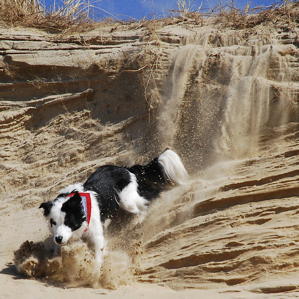

In [6]:
tf.keras.preprocessing.image.array_to_img(encoder_input[1861])

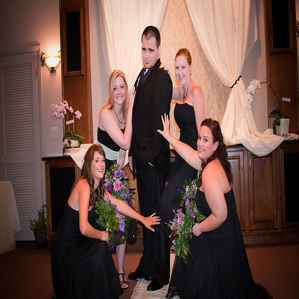

In [7]:
tf.keras.preprocessing.image.array_to_img(encoder_input[6672])

The captions indexd 9305, 33360 are very short and do not describe the image properly.

In [8]:
captions[9305] = 'A black and white dog is running down a sandy mountain.'
captions[33360] = 'A man dressed in formals is surrounded by 4 women with flowers.'

#### Create dictionaries and convert texts to number

In [9]:
word2seq = {} # word -> number
seq2word = {} # number -> word

unwanted = '''1234567890!()-[]{};:'"\,<>./?@#$%^&*_~''' # A list of numbers, punctuations and special characters

word2seq[''] = 0
seq2word[0] = ''

word2seq['ST'] = 1 # Start Token
seq2word[1] = 'ST'

word2seq['ET'] = 2 # End Token
seq2word[2] = 'ET'

caps = []
ind = 2 # indexing start from 3, incremented later, check line 30
pad_len = 20 # We will consider the maximum length of the captions to be 20 + 1

nlp = spacy.load('en_core_web_sm',disable=["tagger", "parser"]) # Load spacy stats model

for i in range(len(captions)):
    
    doc = nlp(captions[i])
    sent = []
    arr = np.zeros([pad_len + 2]) # padding all comments with zero upto the size of avgerage
    arr[0] = 1
    
    for txt in doc:
        
        if str(txt) not in unwanted : # To remove the unwanted characters
            
            if txt.is_stop == False: # To remove Spacy STOP words

                low_txt = txt.text.lower() # Convert all characters to lower case
            
                if low_txt not in word2seq:
                
                    ind = ind + 1
                    word2seq[low_txt] = ind
                    seq2word[ind] = low_txt
                
                sent.append(word2seq[low_txt])
        
    sent.append(word2seq['ET'])
    
    arr[1:len(np.stack(sent[:(pad_len+1)]))+1] = np.stack(sent[:(pad_len+1)])
    caps.append(arr)
    
decoder_stuff = np.stack(caps)

#### Cross verify

 total number of images : 8091 
 total number of captions : 40455
 length of dictionary : 8265 

['ST', 'person', 'walking', 'snowy', 'hill', 'ET', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
A person is walking up a snowy hill


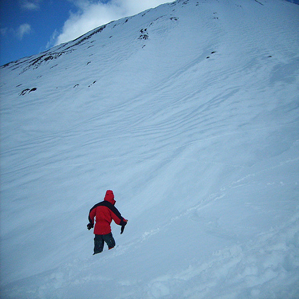

In [12]:
print(' total number of images :',len(encoder_input),'\n','total number of captions :',len(decoder_stuff))
print(' length of dictionary :',len(word2seq),'\n')

lis = []
numb = 4321

for i in decoder_stuff[numb]:
    lis.append(seq2word[i])

print(lis)
print(captions[numb])

tf.keras.preprocessing.image.array_to_img(encoder_input[numb//5])

Note that each image has 5 captions. Hence 8091 images * 5 = 40455 captions 

In [13]:
print(' length of dictionary :',len(word2seq),'\n')

 length of dictionary : 8265 



#### Save the dictionaries and modified data

In [14]:
# save dictionaries
np.save('word2seq.npy', word2seq) 
np.save('seq2word.npy', seq2word)

In [15]:
# save modified input data
np.save('encoder_input.npy', encoder_input)
np.save('decoder_stuff.npy', decoder_stuff)